# LGBloch Demo Notebook

This repository implements the theoretical framework from:

**Conditions for Quantum Violation of Macrorealism in Large-spin Limit** (arXiv:2505.13162 [quant-ph])

This demo showcases three key results:
1. Higher-order ELGIs reveal stronger violations in large-spin systems
2. Entropic, Standard, and Wigner LGIs have largely complementary violation regions
3. ELGIs can detect non-Markovian dynamics through conditional mutual information

## Usage

Run cells sequentially. Each section demonstrates specific theoretical predictions from the paper. Parameters can be modified to explore different regimes or extend the analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lgbloch.viz as viz
from bloch4spin.basis import bloch_init
from bloch4spin.evolution import GeneralizedBlochEvolutionMatrix, GeneralizedBlochState
from bloch4spin.observable import GeneralizedBlochObservable

from lgbloch.engine import (
    distributions_from_deltas,
    distributions_from_times,
    projectors_Jz,
    spin_ops,
)
from lgbloch.lgi import (
    entropic_LGI,
    entropic_LGI_for_order_k,
    entropic_LGI_from_chain_rule,
    standard_LGI_dichotomic,
    wigner_LGI_dichotomic,
)

plt.rcParams['text.usetex'] = True

# Common color palette (used across all experiments)
COLOR_RED = (215/255, 80/255, 94/255)
COLOR_YELLOW = (239/255, 180/255, 96/255)
COLOR_CYAN = (47/255, 127/255, 116/255)
COLOR_BLUE = (88/255, 113/255, 166/255)

### Parallelization

The plotting functions support parallel execution via `joblib`:

- `plot_boolean_region` and `plot_multioutput_curves` use automatic core detection (`backend='auto'`)
- Override with `n_jobs` (e.g., `n_jobs=4`) or `backend` (e.g., `backend='threading'`)
- Windows systems cap at 61 processes for stability
- Global state (e.g., `bloch_init`) is properly handled in worker processes

## Experiment 1: Higher-Order ELGIs in Spin-2 System (Fig. 2)

This section reproduces Figure 2 from the paper, comparing ELGIs of orders 2, 3, and 4 for a spin-2 system under unitary evolution $H = \omega J_y$. The key finding is that higher-order ELGIs exhibit both larger violations and broader violation regions compared to second-order approaches.

**Setup**: spin-2 system ($d=5$), initial maximally mixed state, measurements of $J_z$ at equally spaced time intervals.

In [2]:
# Initialize spin-2 system (d=5 quantum states)
_d = 5
bloch_init(_d)

# Generate SU(5) spin operators
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)

# Create unitary evolution matrix from Hamiltonian H = ωJ_y
L_H_mat_5 = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)

# Initialize maximally mixed state (identity/d)
rho0_5 = np.eye(_d, dtype=complex) / _d
r0_5 = GeneralizedBlochState.from_matrix(rho0_5)

# Set up J_z measurement projectors
obs_list_5 = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# Define evaluation functions for 3-point and 4-point measurements
def evaluate_elgi_3_point(dt):
    """Calculate ELGI values for 3 time points (n=3)."""
    times = [0, dt, 2*dt]
    jps = distributions_from_times(times, d=5, L_mat=L_H_mat_5, r0=r0_5, obs_list=obs_list_5)
    
    devi = entropic_LGI_from_chain_rule(3, jps)
    min2 = entropic_LGI_for_order_k(2, 3, jps)
    min3 = entropic_LGI_for_order_k(3, 3, jps)
    
    return [devi, min2, min3]

def evaluate_elgi_4_point(dt):
    """Calculate ELGI values for 4 time points (n=4)."""
    times = [0, dt, 2*dt, 3*dt]
    jps = distributions_from_times(times, d=5, L_mat=L_H_mat_5, r0=r0_5, obs_list=obs_list_5)
    
    devi = entropic_LGI_from_chain_rule(4, jps)
    min2 = entropic_LGI_for_order_k(2, 4, jps)
    min3 = entropic_LGI_for_order_k(3, 4, jps)
    min4 = entropic_LGI_for_order_k(4, 4, jps)
    
    return [devi, min2, min3, min4]

Parallel execution (loky): 99 chunks on 52 workers.


[Parallel(n_jobs=52)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=52)]: Done  16 out of  99 | elapsed:    3.4s remaining:   18.2s
[Parallel(n_jobs=52)]: Done  36 out of  99 | elapsed:    3.6s remaining:    6.3s
[Parallel(n_jobs=52)]: Done  56 out of  99 | elapsed:    3.7s remaining:    2.8s
[Parallel(n_jobs=52)]: Done  76 out of  99 | elapsed:    4.0s remaining:    1.1s
[Parallel(n_jobs=52)]: Done  96 out of  99 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=52)]: Done  99 out of  99 | elapsed:    4.3s finished


Parallel execution (loky): 99 chunks on 52 workers.


[Parallel(n_jobs=52)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=52)]: Done  16 out of  99 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=52)]: Done  36 out of  99 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=52)]: Done  56 out of  99 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=52)]: Done  76 out of  99 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=52)]: Done  96 out of  99 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=52)]: Done  99 out of  99 | elapsed:    0.4s finished


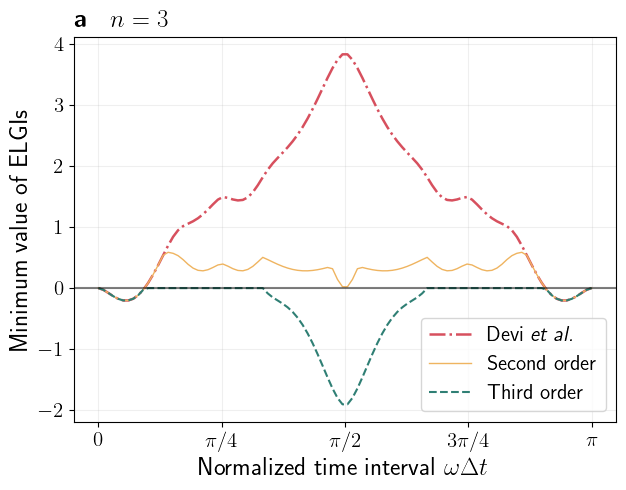

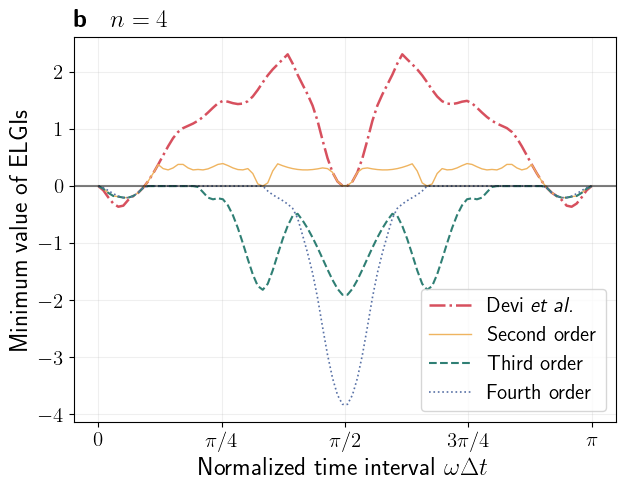

In [3]:
# Generate plots for both 3-point and 4-point measurements
delta_ts = np.linspace(0, np.pi, 100)

# Common pi-based tick marks for both plots
ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
ticklabels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]

# Plot (a): Three-point ELGIs
fig, ax = viz.plot_multioutput_curves(
    evaluate_elgi_3_point,
    delta_ts,
    label=[r'Devi {\itshape et al.}', r'Second order', r'Third order'],
    color=[COLOR_RED, COLOR_YELLOW, COLOR_CYAN],
    linewidth=[1.8, 1.0, 1.5],
    linestyle=['-.', '-', '--'],
    n_jobs=52
)

ax.set(xlabel=r'Normalized time interval $\omega\Delta t$', 
       ylabel=r'Minimum value of ELGIs')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-2, -1, 0, 1, 2, 3, 4])
ax.set_yticklabels(["$-2$", "$-1$", "$0$", "$1$", "$2$", "$3$", "$4$"])

ax.legend(loc='lower right', fontsize=15)
ax.axhline(0, color='k', linestyle='-', alpha=0.5)
ax.text(0.0, 1.07, r'{\bfseries a}\quad$n=3$', transform=ax.transAxes,
        fontsize=18, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/3-point-ELGIs.png', dpi=300, bbox_inches='tight')

# Plot (b): Four-point ELGIs
fig, ax = viz.plot_multioutput_curves(
    evaluate_elgi_4_point,
    delta_ts,
    label=[r'Devi {\itshape et al.}', r'Second order', r'Third order', r'Fourth order'],
    color=[COLOR_RED, COLOR_YELLOW, COLOR_CYAN, COLOR_BLUE],
    linewidth=[1.8, 1.0, 1.5, 1.2],
    linestyle=['-.', '-', '--', ':'],
    n_jobs=52
)

ax.set(xlabel=r'Normalized time interval $\omega\Delta t$', 
       ylabel=r'Minimum value of ELGIs')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-4, -3, -2, -1, 0, 1, 2])
ax.set_yticklabels(["$-4$", "$-3$", "$-2$", "$-1$", "$0$", "$1$", "$2$"])

ax.legend(loc='lower right', fontsize=15)
ax.axhline(0, color='k', linestyle='-', alpha=0.5)
ax.text(0.0, 1.07, r'{\bfseries b}\quad$n=4$', transform=ax.transAxes,
        fontsize=18, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/4-point-ELGIs.png', dpi=300, bbox_inches='tight')

## Experiment 2: Comparative Analysis of LGI Types (Fig. 3)

This section reproduces Figure 3, comparing three approaches to testing macrorealism in a qubit system with dissipation:

1. **ELGI**: Entropic Leggett-Garg Inequalities (this work)
2. **SLGI**: Standard Leggett-Garg Inequalities (Halliwell)
3. **WLGI**: Wigner Leggett-Garg Inequalities (Saha et al.)

The analysis shows that these three methods have largely complementary violation regions, highlighting the value of multi-pronged approaches to quantum non-classicality detection.

**Setup**: qubit system ($d=2$), Hamiltonian $H = \omega J_y$, Lindblad dissipation $L = \sqrt{\gamma} J_-$.

In [4]:
# Initialize qubit system (d=2)
_d = 2
bloch_init(_d)

# Generate SU(2) spin operators for qubit
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)

# Create evolution matrices for unitary and dissipative dynamics
L_H_mat = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)
L_K_mat = GeneralizedBlochEvolutionMatrix.from_Lindblad(Jm)

# Initialize maximally mixed state
rho0 = np.eye(_d, dtype=complex) / _d
r0 = GeneralizedBlochState.from_matrix(rho0)

# Set up J_z measurement projectors
obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# Set violation detection threshold
ATOL = 1e-10

# Set π-based tick marks (used for all plots in this experiment)
ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2, 3*np.pi, 7*np.pi/2, 4*np.pi]
ticklabels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$",
                 r"$5\pi/2$", r"$3\pi$", r"$7\pi/2$", r"$4\pi$"]

# Global engine dict - this will be modified to update parameters
current_engine = {
    "d": _d,
    "L_mat": L_H_mat,
    "r0": r0,
    "obs_list": obs_list,
}

# Define boolean function for three-point LGI violation detection
def bool_LG_three_point(t12, t23):
    """Check for LGI violations at two time intervals (t12, t23)."""
    deltas = (t12, t23)
    jps = distributions_from_deltas(deltas, **current_engine)

    e_min = entropic_LGI(3, jps)
    s_min = standard_LGI_dichotomic(3, jps)
    w_min = wigner_LGI_dichotomic(3, jps)

    return [e_min < -ATOL, s_min < -ATOL, w_min < -ATOL]

Parallel execution (loky): 209 chunks on 52 workers.


[Parallel(n_jobs=52)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=52)]: Done  58 tasks      | elapsed:  1.1min
[Parallel(n_jobs=52)]: Done 148 out of 209 | elapsed:  2.0min remaining:   49.2s
[Parallel(n_jobs=52)]: Done 190 out of 209 | elapsed:  2.3min remaining:   13.9s
[Parallel(n_jobs=52)]: Done 209 out of 209 | elapsed:  2.7min finished


Boolean region data saved to: data\3-point-LGIs-a-1000.npz


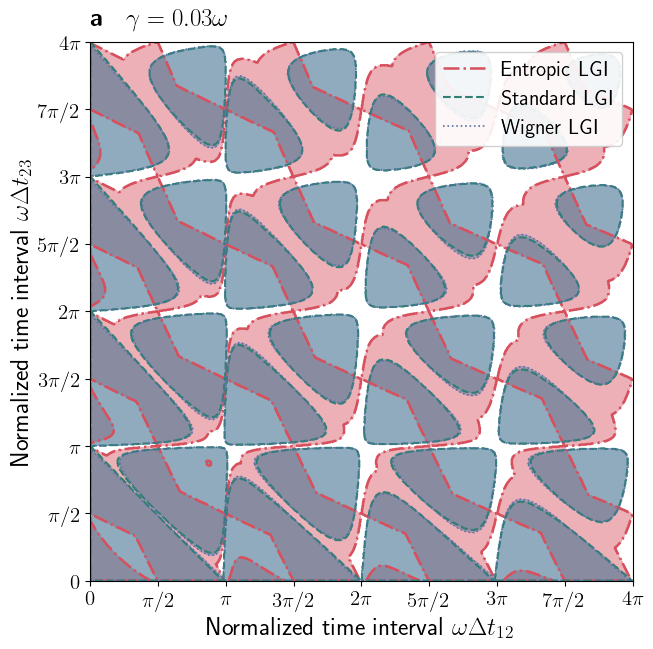

In [5]:
# Configure system parameters for Figure 3a: γ = 0.03ω
current_engine["L_mat"] = L_H_mat + 0.03 * L_K_mat  # Weak dissipation
current_engine["r0"] = r0 + 0.0 * Jz                # Initial state (maximally mixed)

# Set parameter ranges for time intervals
t12_range = (0.0, 4 * np.pi)
t23_range = (0.0, 4 * np.pi)

# Generate violation region plot (high resolution: n=1000)
fig, ax = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=1000,
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[COLOR_RED, COLOR_CYAN, COLOR_BLUE],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='overlay',
    save_data="data/3-point-LGIs-a-1000.npz",
    n_jobs=52
)

ax.set(xlabel=r'Normalized time interval $\omega\Delta t_{12}$',
       ylabel=r'Normalized time interval $\omega\Delta t_{23}$')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.text(0.0, 1.06, r'{\bfseries a}\quad$\gamma=0.03\omega$', transform=ax.transAxes,
        fontsize=18, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/plot-3-point-LGIs-a.png', dpi=300, bbox_inches='tight')

Parallel execution (loky): 209 chunks on 52 workers.


[Parallel(n_jobs=52)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=52)]: Done  58 tasks      | elapsed:  1.1min
[Parallel(n_jobs=52)]: Done 148 out of 209 | elapsed:  1.9min remaining:   48.0s
[Parallel(n_jobs=52)]: Done 190 out of 209 | elapsed:  2.3min remaining:   13.9s
[Parallel(n_jobs=52)]: Done 209 out of 209 | elapsed:  2.6min finished


Boolean region data saved to: data\3-point-LGIs-b-1000.npz


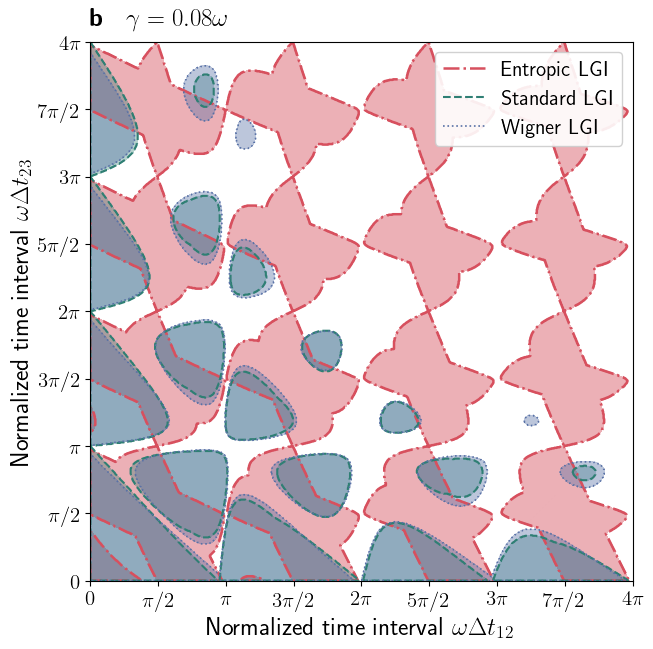

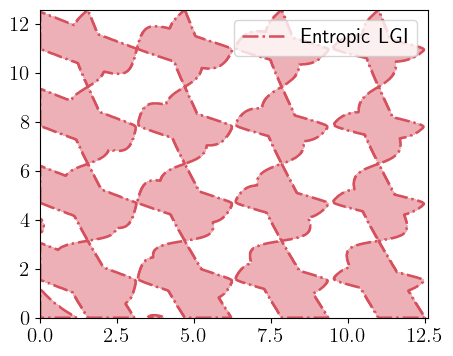

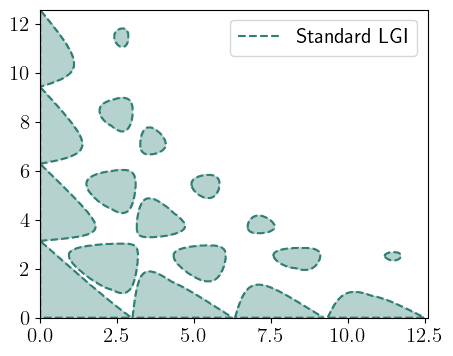

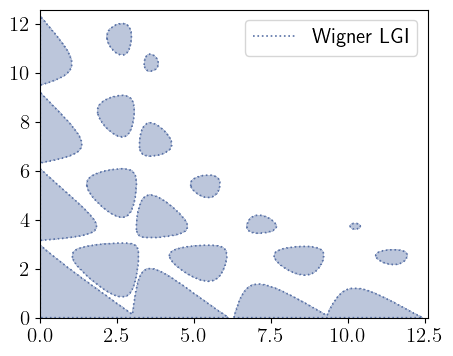

In [6]:
# Configure system parameters for Figure 3b: γ = 0.08ω
current_engine["L_mat"] = L_H_mat + 0.08 * L_K_mat  # Stronger dissipation
current_engine["r0"] = r0 + 0.0 * Jz

# Generate both overlay and separate plots
fig, ax, separate_figs = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=1000,
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[COLOR_RED, COLOR_CYAN, COLOR_BLUE],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='both',
    save_data="data/3-point-LGIs-b-1000.npz",
    n_jobs=52
)

ax.set(xlabel=r'Normalized time interval $\omega\Delta t_{12}$',
       ylabel=r'Normalized time interval $\omega\Delta t_{23}$')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.text(0.0, 1.06, r'{\bfseries b}\quad$\gamma=0.08\omega$', transform=ax.transAxes,
        fontsize=18, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/plot-3-point-LGIs-b.png', dpi=300, bbox_inches='tight')

### Demonstrate data reuse: Replot from saved .npz files
This shows how to reproduce figures without re-running simulations

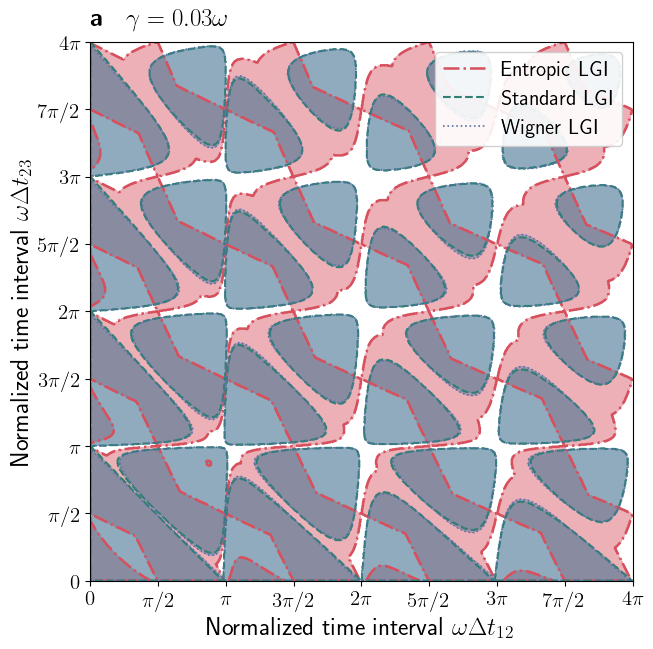

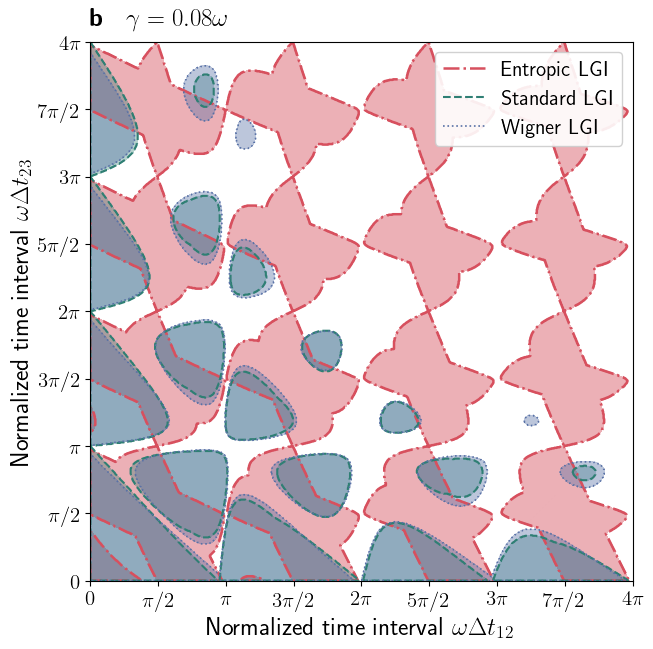

In [7]:
# Replot Figure 3a
fig, ax = viz.replot_boolean_region(
    "data/3-point-LGIs-a-1000.npz",
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[COLOR_RED, COLOR_CYAN, COLOR_BLUE],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='overlay'
)

ax.set(xlabel=r'Normalized time interval $\omega\Delta t_{12}$',
       ylabel=r'Normalized time interval $\omega\Delta t_{23}$')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.text(0.0, 1.06, r'{\bfseries a}\quad$\gamma=0.03\omega$', transform=ax.transAxes,
        fontsize=18, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/replot-3-point-LGIs-a.png', dpi=300, bbox_inches='tight')

# Replot Figure 3b
fig, ax = viz.replot_boolean_region(
    "data/3-point-LGIs-b-1000.npz",
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[COLOR_RED, COLOR_CYAN, COLOR_BLUE],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='overlay'
)

ax.set(xlabel=r'Normalized time interval $\omega\Delta t_{12}$',
       ylabel=r'Normalized time interval $\omega\Delta t_{23}$')
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.text(0.0, 1.06, r'{\bfseries b}\quad$\gamma=0.08\omega$', transform=ax.transAxes,
        fontsize=18, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/replot-3-point-LGIs-b.png', dpi=300, bbox_inches='tight')

## Experiment 3: Non-Markovian Detection via ELGIs (Fig. 4)

This section reproduces Figure 4, demonstrating how ELGIs can detect non-Markovian memory effects through the conditional mutual information

$$\begin{equation}\mathcal{D}_{1,3} = H(Q_1,Q_2) + H(Q_2,Q_3) - H(Q_1,Q_2,Q_3) - H(Q_2).\end{equation}$$

Negative values of $\mathcal{D}_{1,3}$ indicate non-Markovian dynamics where information flows backward from the environment.

**Setup**: Four-level system simulating qubit-sink coupling, exploring how ELGI violations depend on dissipation rate γ.

In [8]:
# Define four-level system operators: |0⟩, |1⟩, |e⟩, |g⟩
def get_four_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma):
    """Construct operators for four-level qubit-sink system."""
    bloch_init(4)
    
    # Hamiltonian with energy levels and couplings
    H = np.zeros((4, 4), dtype=complex)
    H[0, 0] = E0
    H[1, 1] = E1
    H[2, 2] = Ee
    H[3, 3] = Eg
    H[0, 1] = omega0
    H[1, 0] = np.conj(omega0)
    H[1, 2] = omega
    H[2, 1] = np.conj(omega)
    
    L_mat_H = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(H)
    
    # Lindblad dissipation operator
    L = np.zeros((4, 4), dtype=complex)
    L[3, 2] = np.sqrt(gamma)  # |g⟩⟨e|
    L_mat_L = GeneralizedBlochEvolutionMatrix.from_Lindblad(L)
    
    L_mat = L_mat_H + L_mat_L
    
    # Initial state: equal superposition of |0⟩ and |1⟩
    rho0 = np.zeros((4, 4), dtype=complex)
    rho0[0, 0] = 0.5
    rho0[1, 1] = 0.5
    r0 = GeneralizedBlochState.from_matrix(rho0)
    
    # Measurement projectors for |0⟩ and |1⟩ states
    obs_list = [GeneralizedBlochObservable.from_projector(P) 
                for P in projectors_Jz(4, indices=(0, 1))]
    
    return L_mat, r0, obs_list

# Define effective three-level system approximation
def get_effective_three_level_operators(E0, E1, Ee, Eg, omega0, omega, gamma):
    """Effective three-level description after adiabatic elimination."""
    bloch_init(3)
    
    H = np.zeros((3, 3), dtype=complex)
    H[0, 0] = E0
    H[1, 1] = E1
    H[2, 2] = Eg
    H[0, 1] = omega0
    H[1, 0] = np.conj(omega0)
    
    # Effective decay rate from second-order perturbation theory
    Delta = Ee - E1
    Gamma_eff = np.abs(omega)**2 * gamma / (Delta**2 + (gamma/2)**2)
    
    L = np.zeros((3, 3), dtype=complex)
    L[2, 1] = np.sqrt(Gamma_eff)  # Effective |g⟩⟨1|
    L_mat_H = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(H)
    L_mat_L = GeneralizedBlochEvolutionMatrix.from_Lindblad(L)
    L_mat = L_mat_H + L_mat_L

    rho0 = np.zeros((3, 3), dtype=complex)
    rho0[0, 0] = 0.5
    rho0[1, 1] = 0.5
    r0 = GeneralizedBlochState.from_matrix(rho0)
    
    obs_list = [GeneralizedBlochObservable.from_projector(P)
                for P in projectors_Jz(3, indices=(0, 1))]
    
    return L_mat, r0, obs_list

# Function to compute conditional mutual information D_{1,3}
def calc_specific_elgi(jps):
    """Calculate D_{1,3} = I(Q1; Q3 | Q2) for non-Markovian detection."""
    dist = jps.distributions
    from lgbloch.lgi import shannon_entropy
    
    h12 = shannon_entropy(dist[(1, 2)])
    h23 = shannon_entropy(dist[(2, 3)])
    h123 = shannon_entropy(dist[(1, 2, 3)])
    h2 = shannon_entropy(dist[(2,)])
    
    return h12 + h23 - h123 - h2

In [9]:
# System parameters (energy units where ω = 1)
E0 = 0.0      # Ground state energy
E1 = 2.58     # |1⟩ state energy
Ee = 4.79     # Excited state |e⟩ energy
Eg = -0.003   # Sink state |g⟩ energy
omega0 = 1.0  # Coupling strength
omega = 1.0   # Transition frequency

# Dissipation rates to explore (in units of ω)
gamma_list = [0.1, 0.3, 0.5, 0.7]

# Initial time offset
t_start = np.pi / (4 * omega0)

def evaluate_lgi(dt, gamma_list=gamma_list):
    """Evaluate ELGI values across different dissipation rates."""
    # Three measurement times: t1, t2, t3
    times = [t_start, t_start + dt, t_start + 2*dt]
    
    results = []
    for gamma in gamma_list:
        # Compute joint probability distributions
        L_mat_4, r0_4, obs_list_4 = get_four_level_operators(
            E0, E1, Ee, Eg, omega0, omega, gamma)
        bloch_init(4)
        jps_4 = distributions_from_times(
            times, d=4, L_mat=L_mat_4, r0=r0_4, obs_list=obs_list_4)
        
        # Calculate conditional mutual information
        val_4 = calc_specific_elgi(jps_4)
        results.append(val_4)
    
    return results

Parallel execution (loky): 119 chunks on 52 workers.


[Parallel(n_jobs=52)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=52)]: Done  40 out of 119 | elapsed:    1.0s remaining:    2.0s
[Parallel(n_jobs=52)]: Done  64 out of 119 | elapsed:    1.9s remaining:    1.6s
[Parallel(n_jobs=52)]: Done  88 out of 119 | elapsed:    1.9s remaining:    0.6s
[Parallel(n_jobs=52)]: Done 112 out of 119 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=52)]: Done 119 out of 119 | elapsed:    2.7s finished


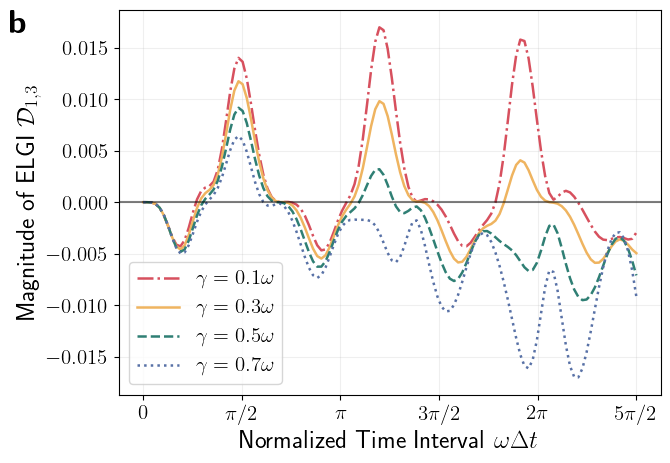

In [10]:
# Generate Figure 4: ELGI violations vs time interval for different γ
delta_ts = np.linspace(0, 5*np.pi/2, 120)

fig, ax = viz.plot_multioutput_curves(
    lambda dt: evaluate_lgi(dt, gamma_list=gamma_list),
    delta_ts,
    label=[fr'$\gamma={g}\omega$' for g in gamma_list],
    color=[COLOR_RED, COLOR_YELLOW, COLOR_CYAN, COLOR_BLUE],
    linewidth=[1.8, 1.8, 1.8, 1.8],
    linestyle=['-.', '-', '--', ':'],
    n_jobs=52
)

ax.set(xlabel=r'Normalized Time Interval $\omega\Delta t$',
       ylabel=r'Magnitude of ELGI $\mathcal{D}_{1,3}$')

# Configure π-based tick marks
ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi, 5*np.pi/2]
ticklabels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$", r"$5\pi/2$"]
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)

ax.legend(loc='lower left', fontsize=15)
ax.axhline(0, color='k', linestyle='-', alpha=0.5)
ax.text(-0.20, 1.00, r'{\bfseries b}', transform=ax.transAxes,
        fontsize=24, verticalalignment='top', horizontalalignment='left')

fig.savefig('pic/non-Markovian.png', dpi=300, bbox_inches='tight')

## Summary

This demo reproduces three key results from the paper:

1. **Higher-order ELGIs** (3rd, 4th order) show stronger violations than traditional 2nd-order LGIs in large-spin systems, with broader violation regions.

2. **ELGIs, SLGIs, and WLGIs** detect quantum non-classicality in largely complementary parameter regimes, suggesting that multi-method approaches are valuable for comprehensive studies.

3. **ELGIs can detect non-Markovianity** through negative values of conditional mutual information, providing a new information-theoretic probe of open quantum system dynamics.

### Extending This Work

The lgbloch library can be used to:
- Study larger spin quantum numbers (s=3, 5/2, 4, etc.)
- Explore different Hamiltonians and measurement operators
- Investigate other types of open system dynamics
- Implement higher-order ELGIs (5-point, 6-point correlations)
- Compare theoretical predictions with experimental data

For details, see: **"Conditions for Quantum Violation of Macrorealism in Large-spin Limit"** (arXiv:2505.13162 [quant-ph])